# 3. Поиск сайтов протеолиза белков протеосомой по данным IEDB

Антон Смирнов, 16.11.2022

## Загрузка данных об эпитопах

In [1]:
from io import StringIO

import pandas as pd
import mysql.connector as con
from Bio import Entrez,SeqIO
import re
#import requests
from urllib.error import HTTPError
import matplotlib.pyplot as plt

In [2]:
Entrez.email = "anton.smirnov.9910@gmail.com"
Entrez.api_key = "67a161eb14f134f9d7e50e111f957429f808"

In [3]:
def isUniprotID(id):
    return re.match("([OPQ][0-9][A-Z0-9]|[A-NR-Z][0-9][A-Z])[A-Z0-9][A-Z0-9][0-9]([A-Z][A-Z0-9][A-Z0-9][0-9])?",id) is not None

In [4]:
def typeSource(id):
    if isUniprotID(id):
        return "Uniprot"
    elif id[0:3] == "SRC":
        return "SRC"
    elif id[0:2] == "NP" or re.match("\\w+",id[0:3]):
        return "NCBI"
    else:
        return "Other"

In [5]:
def isCorrectSequence(seq):
    alphabet = list("ACDEFGHIKLMNPQRSTVWY")
    seq = seq.strip()
    for i in range(0,len(seq)):
        if seq[i] not in alphabet:
            return False
    return True

In [6]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

Для описания сайтов разрезания берем С-конец эпитопа. Для полноты картины нужна аминокислота, следующая после С-конца эпитопа. Для этого нужна референсная послежовательность и большая часть кода посвящена их извлечению.

Загрузка заготовленных с помощью скрипта create_lin_epitope_samples_by_assay таблиц

In [7]:
try:
    mydb = con.connect(host="localhost", database = 'iedb',user="stotoshka", passwd="meowmeow",use_pure=True)

    pos_elution = pd.read_sql("SELECT * FROM pos_epi_elution;",mydb)
    pos_bind = pd.read_sql("SELECT * FROM pos_epi_bind;",mydb)
    pos_tcell = pd.read_sql("SELECT * FROM pos_epi_tcell",mydb)

    neg_elution = pd.read_sql("SELECT * FROM neg_epi_elution;",mydb)
    neg_bind = pd.read_sql("SELECT * FROM neg_epi_bind;",mydb)
    neg_tcell = pd.read_sql("SELECT * FROM neg_epi_tcell",mydb)

    print("Elution - Positive: " + str(pos_elution.shape) + " ;Negative: " + str(neg_elution.shape))
    print("Bind - Positive: " + str(pos_bind.shape) + " ;Negative: " + str(neg_bind.shape))
    print("Tcell - Positive: " + str(pos_tcell.shape) + " ;Negative: " + str(neg_tcell.shape))

except Exception as e:
    print(str(e))
finally:
    mycursor = mydb.cursor()
    #drop для возможности повторного запуска скрипта
    sql = "DROP TABLE IF EXISTS pos_human_mhcI_from_elution;" \
          "DROP TABLE IF EXISTS pos_human_mhcI_from_bind;" \
          "DROP TABLE IF EXISTS pos_human_mhcI_from_tcell;" \
          "DROP TABLE IF EXISTS neg_human_mhcI_from_elution;" \
          "DROP TABLE IF EXISTS neg_human_mhcI_from_bind;" \
          "DROP TABLE IF EXISTS neg_human_mhcI_from_tcell;" \
          "DROP VIEW IF EXISTS human_linear_epi;" \
          "DROP VIEW IF EXISTS pos_epi_elution;DROP VIEW IF EXISTS pos_epi_bind;DROP VIEW IF EXISTS pos_epi_tcell;" \
          "DROP VIEW IF EXISTS neg_epi_elution;DROP VIEW IF EXISTS neg_epi_bind; DROP VIEW IF EXISTS neg_epi_tcell;"
    mycursor.execute(sql,multi=True)
    mydb.close()

/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/stotoshka/Soft/anaconda3/envs/research/lib/python3.9/site-packages/pandas

Elution - Positive: (13266, 8) ;Negative: (0, 8)
Bind - Positive: (33295, 8) ;Negative: (45084, 8)
Tcell - Positive: (10287, 8) ;Negative: (30816, 8)


Собрать все датасеты вместе

In [8]:
combined = pd.concat([pos_elution,pos_tcell,pos_bind,neg_tcell,neg_bind,neg_elution]).reset_index(drop=True)
print(combined.shape)
combined.head()

(132748, 8)


,curated_epitope_id,linear_peptide_seq,source_antigen_accession,source_organism_org_id,e_ref_start,e_ref_end,mhc_allele_name,class
0,1433183.0,AYKKQFSQY,NP_000960.2,9606.0,217.0,225.0,HLA-A*30:02,I
1,1433183.0,AYKKQFSQY,NP_000960.2,9606.0,217.0,225.0,HLA-A*30:04,I
2,316179.0,YTIPPGHQV,AAB39951.1,9606.0,399.0,407.0,HLA-B*15:16,I
3,316182.0,ITNTVGSSI,AAA58502.1,9606.0,445.0,453.0,HLA-B*15:16,I
4,316178.0,LTDPSQRLV,CAA61107.1,9606.0,370.0,378.0,HLA-B*15:16,I


In [9]:
combined = combined[combined["linear_peptide_seq"].apply(isCorrectSequence)]
combined.shape

(132746, 8)

Было обнаружено три типа идентификатора белков:
    - Идентификаторы NCBI (NP_<номер>, ###<номер>)
    - Идентификаторы Uniprot (в интернете есть регулярное выражение для проверки)
    - Неизвестная БД (SRC<номер>)

In [10]:
combined["typeSource"] = combined["source_antigen_accession"].apply(typeSource)
combined["typeSource"].value_counts()

Uniprot    104184
NCBI        27489
SRC          1073
Name: typeSource, dtype: int64

Идентификаторы SRC принадлежат неустановленной мной БД, поэтому будут исключены из рассмотрения

In [11]:
combined = combined[~combined['source_antigen_accession'].str.startswith("SRC")]

In [12]:
num_unique_antigens = combined["source_antigen_accession"].nunique()
num_unique_epitopes = combined["linear_peptide_seq"].nunique()
print(f"Unique epitopes = {num_unique_epitopes}; Unique antigens = {num_unique_antigens}.")

Unique epitopes = 36786; Unique antigens = 9957.


## Загрузка референсных последовательностей белков

Загрузка с помощью API Uniprot недокачала порядка 1000 последовательностей (см. код ниже), поэтому было решено всё скачивать через Entrez.

In [13]:
ids_antigens = combined["source_antigen_accession"].unique()
#NOT RUN! TOO LONG EXECUTION
printProgressBar(0, len(ids_antigens))
ant_len = len(ids_antigens)
with open("../data/iedb_refs.fasta", "w") as fasta, open("../logs/log_iedb.txt","w") as log:
    for i, acc_num in enumerate(ids_antigens):
        try:
            handle = Entrez.efetch(id = acc_num, db = "protein", rettype="fasta", retmode="text")
            fasta.write(handle.read())
        except HTTPError as e:
            print(acc_num)
            log.write(f"{acc_num} {e}\n")
        printProgressBar(i, ant_len)


H7C4X7███████████████████████████---------------------------------------------------------------------| 31.6% 


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [ ]:
unique_accessions = pd.DataFrame(combined['source_antigen_accession'].unique(),columns=["id"])
unique_accessions["type"] = unique_accessions["id"].apply(typeSource)
unique_accessions["type"].value_counts()

In [13]:
unique_accessions.head()

,id,type
0,NP_000960.2,NCBI
1,AAB39951.1,NCBI
2,AAA58502.1,NCBI
3,CAA61107.1,NCBI
4,AAA35786.1,NCBI


### Uniprot

In [14]:
# NOT RUN! LONG EXECUTION
# ant_len = len(uniprot_id.index)
# print(ant_len)
# printProgressBar(0, ant_len)
# with open("../data/antigen_seqs_uniprot.fasta", "w") as fasta, open("../logs/log_uniprot.txt","w") as log:
#     for i, acc_num in enumerate(uniprot_id.index):
#         try:
#             link = f"https://rest.uniprot.org/uniprotkb/{acc_num}.fasta"
#             res = requests.get(link)
#             if res.status_code == 200:
#                 fasta.write(res.text)
#                 log.write(f"{i} {acc_num} Success {res.text[0:20]}\n")
#             else:
#                 print(f"{acc_num} couldn find in uniprot. Status code = {res.status_code}")
#                 log.write(f"{acc_num} {res.status_code}\n")
#         except Exception as e:
#             log.write(f"{acc_num} {e}\n")
#         finally:
#             printProgressBar(i, ant_len)

In [18]:
uniprot_id = list(unique_accessions.loc[unique_accessions["type"] == "Uniprot","id"])

In [19]:
#NOT RUN! TOO LONG EXECUTION
# printProgressBar(0, len(uniprot_id))
# ant_len = len(uniprot_id)
# with open("../data/antigen_seqs_uniprot1.fasta", "w") as fasta, open("../logs/log_uniprot1.txt","w") as log:
#     for i, acc_num in enumerate(uniprot_id):
#         try:
#             handle = Entrez.efetch(id = acc_num, db = "protein", rettype="fasta", retmode="text")
#             fasta.write(handle.read())
#         except HTTPError as e:
#             print(acc_num)
#             log.write(f"{acc_num} {e}\n")
#         printProgressBar(i, ant_len)


H7C4X7████████████████████████████████----------------------------------------------------------------| 36.7% 
M0QX16███████████████████████████████████████████████████████-----------------------------------------| 59.8% 
A9J1J8.1███████████████████████████████████████████████████████---------------------------------------| 61.3% 
A2JGV3.1██████████████████████████████████████████████████████████------------------------------------| 64.2% 
F5H1F0█████████████████████████████████████████████████████████████-----------------------------------| 65.6% 
H0Y7T5█████████████████████████████████████████████████████████████-----------------------------------| 65.6% 
Q5SS57.1██████████████████████████████████████████████████████████████--------------------------------| 68.6% 
Q6ICJ4.1███████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 
Q89226.1██████████████████████████████████████████████████████████████████████████████████████--------| 92.1% 
G

Есть последовательности, которые не удалось скачать. Необходимо исключить записи с такими ИД

In [20]:
ids = []
with open("../logs/log_uniprot1.txt", "r") as l:
    for i in l.readlines():
        ids.append(re.split("\\s",i)[0])
print(ids)

['H7C4X7', 'M0QX16', 'A9J1J8.1', 'A2JGV3.1', 'F5H1F0', 'H0Y7T5', 'Q5SS57.1', 'Q6ICJ4.1', 'Q89226.1', 'G3V2T4']


In [21]:
combined = combined[~combined['source_antigen_accession'].isin(ids)]

In [22]:
uniprot_id = list(combined.loc[(combined["typeSource"] == "Uniprot"),"source_antigen_accession"].unique())

### NCBI

In [23]:
ncbi_id = list(unique_accessions.loc[unique_accessions["type"] == "NCBI","id"])

In [78]:
#NOT RUN! TOO LONG EXECUTION
# printProgressBar(0, len(ncbi_id.index))
# ant_len = len(ncbi_id.index)
# with open("../data/antigen_seqs_ncbi.fasta", "w") as fasta, open("../logs/log_ncbi.txt","w") as log:
#     for i, acc_num in enumerate(ncbi_id.index):
#         try:
#             handle = Entrez.efetch(id = acc_num, db = "protein", rettype="fasta", retmode="text")
#             fasta.write(handle.read())
#         except HTTPError as e:
#             log.write(f"{acc_num} {e.response}\n")
#         printProgressBar(i, ant_len)


Все последовательности успешно скачались

## Объединим все референсы в один словарь

In [63]:
all_seqs = {}
for seq, ind in zip(SeqIO.parse("../data/antigen_seqs_uniprot1.fasta","fasta"),uniprot_id):
    all_seqs[ind] = seq.seq

In [64]:
for seq, ind in zip(SeqIO.parse("../data/antigen_seqs_ncbi.fasta","fasta"),ncbi_id):
    all_seqs[ind] = seq.seq

In [65]:
print(len(all_seqs.keys()))
print(combined["source_antigen_accession"].nunique())

9947
9947


In [66]:
combined["e_ref_start"] = combined["e_ref_start"].apply(int)
combined["e_ref_end"] = combined["e_ref_end"].apply(int)

Проверим, сколько эпитопов вырезано именно из референсной последовательности

In [74]:
success = 0
success_with_wrong_coords = 0
failed = 0

failed_id = []
for ind in combined.index:
    key = combined.loc[ind,"source_antigen_accession"]
    if combined.loc[ind,"linear_peptide_seq"] in all_seqs[key]:
        #+1 от начала, потому что нумерация в питоне с 0
        #+1 от конца, потому что конец не захватывается при индексации
        if all_seqs[key][combined.loc[ind,"e_ref_start"]+1:combined.loc[ind,"e_ref_end"]+1] == combined.loc[ind, "linear_peptide_seq"]:
            success += 1
        else:
            success_with_wrong_coords += 1
    else:
        failed += 1
        failed_id.append(key)
        print(key)
        print(combined.loc[ind,"linear_peptide_seq"])
        print(str(all_seqs[key][combined.loc[ind,"e_ref_start"]-2:combined.loc[ind,"e_ref_end"]+2]))
        #print(str(uniprot_full_seqs_dict[uniprot.loc[ind,"source_antigen_accession"]]))

print(f"Failed {failed} Success {success} Success_without_coords {success_with_wrong_coords}")

P03452
GVTAACSHAGK
GVTAACSHEGKSSF
P08779
ISSVLAGASCPA
RISSVLAGGSCRAPS
P08779
ISSVLAGASCPA
RISSVLAGGSCRAPS
P08779
ISSVLAGASCPA
RISSVLAGGSCRAPS
QHD43415.1
GNAAISDYDYYRYNl
GLNDNLLEILQKEKVNIN
QHD43415.1
GNAAISDYDYYRYNl
GLNDNLLEILQKEKVNIN
P03452
GVTAACSHAGK
GVTAACSHEGKSSF
Failed 7 Success 4 Success_without_coords 131628


Практически все последовательности не мапируются на референс по указанным координатам, но они присутствуют в нем. Эпитопы, которые совсем не мапируются на референс, необходимо исключить. Они не мапируются из-за небольших различий между референсом.

In [75]:
combined = combined[~combined["source_antigen_accession"].isin(failed_id)]

## Сайты расщепления

Поскольку здесь присутствуют данные об экспериментах с разным дизайном, в качестве сайта разрезания будем брать только С-конец пептидов. Также исключим повторяющиеся записи

In [82]:
combined = combined.drop_duplicates(subset="curated_epitope_id", ignore_index = True)

In [84]:
combined.shape

(47178, 11)

In [83]:
def getNextLetterAfterSegment(acc_num,segment):
    seq = all_seqs[acc_num]
    return seq[seq.find(segment)+1]

In [85]:
for i in combined.index:
    combined.loc[i, "N"] = combined.loc[i,"linear_peptide_seq"][-1]
    combined.loc[i, "C"] = getNextLetterAfterSegment(combined.loc[i,"source_antigen_accession"], combined.loc[i,"linear_peptide_seq"])
combined.head()

,curated_epitope_id,linear_peptide_seq,source_antigen_accession,source_organism_org_id,e_ref_start,e_ref_end,mhc_allele_name,class,typeSource,N,C
0,1433183.0,AYKKQFSQY,NP_000960.2,9606.0,217,225,HLA-A*30:02,I,NCBI,Y,Y
1,316179.0,YTIPPGHQV,AAB39951.1,9606.0,399,407,HLA-B*15:16,I,NCBI,V,T
2,316182.0,ITNTVGSSI,AAA58502.1,9606.0,445,453,HLA-B*15:16,I,NCBI,I,T
3,316178.0,LTDPSQRLV,CAA61107.1,9606.0,370,378,HLA-B*15:16,I,NCBI,V,T
4,316176.0,VSYGSIVTY,AAA35786.1,9606.0,295,303,HLA-B*15:16,I,NCBI,Y,S


In [86]:
combined["NC"] = combined["N"] + combined["C"]

/tmp/ipykernel_3512/620725847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined["NC"] = combined["N"] + combined["C"]


In [90]:
round(combined["NC"].value_counts() / len(combined.index),5)

LL    0.05581
VL    0.05437
LE    0.03955
LP    0.03065
KL    0.02630
       ...   
CN    0.00004
CD    0.00004
NC    0.00002
EW    0.00002
DC    0.00002
Name: NC, Length: 398, dtype: float64

In [91]:
freqs = pd.DataFrame(round(combined["N"].value_counts() / len(combined.index),5))
freqs.head()

,N
L,0.23142
Y,0.13697
K,0.12824
V,0.11259
F,0.08362


<AxesSubplot:>

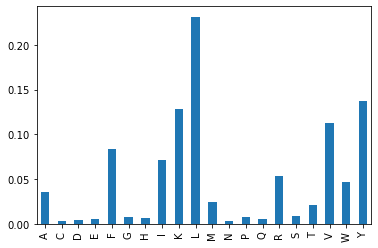

In [94]:
freqs["N"].sort_index().plot.bar()